In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

## Ansatz 2 - RNN + LSTM

In [51]:
df = pd.read_csv('df.csv')

In [52]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/Users/nilst/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/.venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [53]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('label')
    
    # Clean the descriptions - replace NaN with empty string and ensure all items are strings
    descriptions = df["description"].fillna("").astype(str).tolist()
    
    # Convert to tensors
    ds = tf.data.Dataset.from_tensor_slices((descriptions, labels))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [54]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [55]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [56]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[ 0.15670063, -0.3478771 , -0.51390004, ...,  0.09409171,
        -0.4476224 ,  0.79219717],
       [ 0.7806128 ,  0.03171286, -0.18115333, ..., -0.09722158,
        -0.57022905,  0.6306143 ],
       [ 0.09751146,  0.060319  , -0.5003986 , ...,  0.00427925,
         0.07339068,  0.47812003],
       ...,
       [ 0.14693986,  0.32626253, -0.13148096, ..., -0.5442684 ,
         0.03811189,  0.26720753],
       [ 0.22356322,  0.01884564,  0.03609102, ..., -0.01705357,
         0.14507413, -0.05160782],
       [ 0.26280785, -0.06709172,  0.0651651 , ...,  0.03754435,
        -0.37385154,  0.1898995 ]], dtype=float32)>

In [57]:
import tf_keras

model = tf_keras.Sequential([
    hub_layer,
    tf_keras.layers.Dense(16, activation='relu'),
    tf_keras.layers.Dropout(0.4),
    tf_keras.layers.Dense(16, activation='relu'),
    tf_keras.layers.Dropout(0.4),
    tf_keras.layers.Dense(1, activation='sigmoid')
])

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [59]:
model.evaluate(train_data)

7/7 [==============================] - 0s 1ms/step - loss: 0.7003 - accuracy: 0.5150


[0.7002795934677124, 0.5149999856948853]

In [60]:
model.evaluate(valid_data)

1/1 [==============================] - 0s 7ms/step - loss: 0.7048 - accuracy: 0.5600


[0.7047985196113586, 0.5600000023841858]

In [61]:
# history = model.fit(train_data, epochs=3, validation_data=valid_data)

In [62]:
# 


In [63]:
model.evaluate(test_data)

1/1 [==============================] - 0s 9ms/step - loss: 0.8081 - accuracy: 0.3200


[0.8081264495849609, 0.3199999928474426]

In [64]:
from sklearn.model_selection import KFold

def cross_validate_confusion_matrix(df, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_true = []
    all_pred = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        # Split the data
        train = df.iloc[train_idx]
        val = df.iloc[val_idx]
        
        # Create datasets
        train_data = df_to_dataset(train)
        val_data = df_to_dataset(val)
        
        # Train model
        model = tf_keras.Sequential([
            hub_layer,
            tf_keras.layers.Dense(16, activation='relu'),
            tf_keras.layers.Dropout(0.4),
            tf_keras.layers.Dense(16, activation='relu'),
            tf_keras.layers.Dropout(0.4),
            tf_keras.layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer='adam',
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])
        
        model.fit(train_data, epochs=3, verbose=0)
        
        # Get predictions for this fold's validation set
        val_predictions = model.predict(val_data, verbose=0)
        val_predictions = (val_predictions > 0.5).astype(int)
        
        # Store true labels and predictions
        val_labels = np.concatenate([y for x, y in val_data], axis=0)
        all_true.extend(val_labels)
        all_pred.extend(val_predictions)
    
    return np.array(all_true), np.array(all_pred)

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(true_labels, predictions, title="Model Confusion Matrix"):
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Calculate and print metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nModel Metrics:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

2025-01-04 18:25:51.160300: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


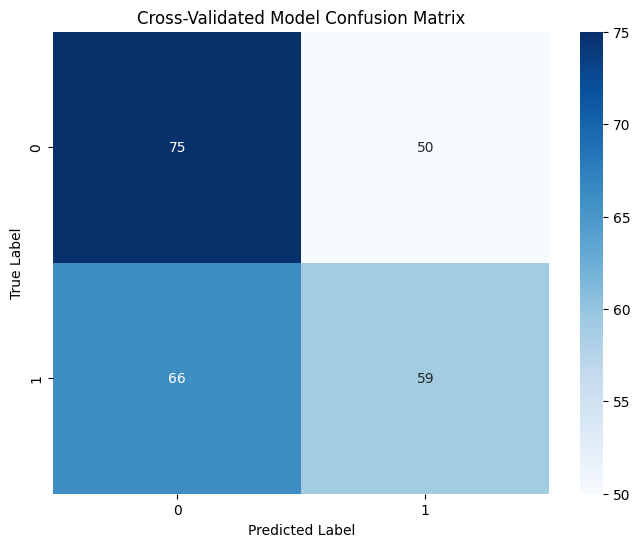


Model Metrics:
Accuracy: 0.536
Precision: 0.541
Recall: 0.472
F1 Score: 0.504


In [66]:
# Get cross-validation results
true_labels, predictions = cross_validate_confusion_matrix(df)

# Plot confusion matrix for all data
plot_confusion_matrix(true_labels, predictions, "Cross-Validated Model Confusion Matrix")

# LSTM

In [67]:
def cross_validate_lstm_confusion_matrix(df, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_true = []
    all_pred = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        # Split the data
        train = df.iloc[train_idx]
        val = df.iloc[val_idx]
        
        # Create datasets
        train_data = df_to_dataset(train)
        val_data = df_to_dataset(val)
        
        # Create and compile model
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(
                input_dim=len(encoder.get_vocabulary()),
                output_dim=32,
                mask_zero=True
            ),
            tf.keras.layers.LSTM(32, use_cudnn=False),  # Disable cuDNN
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])
        
        # Train model
        model.fit(train_data, epochs=5, verbose=0)
        
        # Get predictions for this fold's validation set
        val_predictions = model.predict(val_data, verbose=0)
        val_predictions = (val_predictions > 0.5).astype(int)
        
        # Store true labels and predictions
        val_labels = np.concatenate([y for x, y in val_data], axis=0)
        all_true.extend(val_labels)
        all_pred.extend(val_predictions)
    
    return np.array(all_true), np.array(all_pred)

In [68]:
encoder = tf.keras.layers.TextVectorization(max_tokens=600)
encoder.adapt(train_data.map(lambda text, label: text))

In [69]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'you', 'a', 'to', 'and', 'i', 'is', 'of', 'it',
       'in', 'for', 'on', 'this', 'we', 'your', 'that', 'its', 'with'],
      dtype='<U12')

In [70]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32, use_cudnn=False),  # Disable cuDNN
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [71]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [72]:
model.evaluate(train_data)
model.evaluate(valid_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4933 - loss: 0.6930
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4400 - loss: 0.6933


[0.6933404803276062, 0.4399999976158142]

In [73]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4940 - loss: 0.6931 - val_accuracy: 0.5600 - val_loss: 0.6921
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5431 - loss: 0.6910 - val_accuracy: 0.5600 - val_loss: 0.6908
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5509 - loss: 0.6881 - val_accuracy: 0.5600 - val_loss: 0.6894
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5437 - loss: 0.6819 - val_accuracy: 0.5600 - val_loss: 0.6865
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5756 - loss: 0.6709 - val_accuracy: 0.5600 - val_loss: 0.6803


In [74]:
model.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3600 - loss: 0.7302


[0.7301539778709412, 0.36000001430511475]

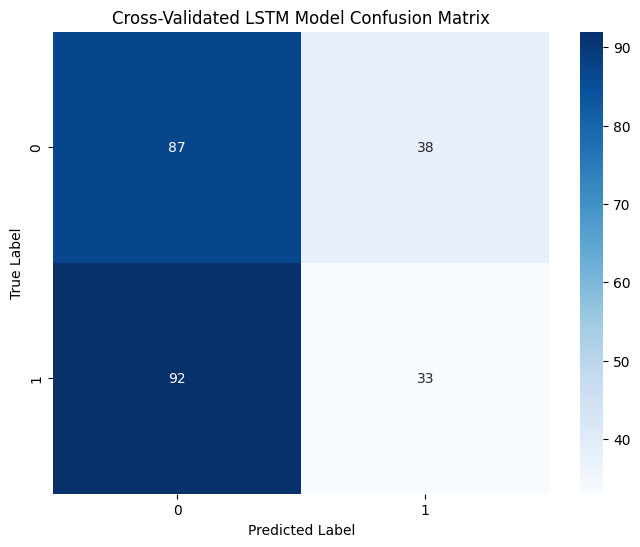


Model Metrics:
Accuracy: 0.480
Precision: 0.465
Recall: 0.264
F1 Score: 0.337


In [75]:
# Get cross-validation results for LSTM
true_labels_lstm, predictions_lstm = cross_validate_lstm_confusion_matrix(df)

# Plot confusion matrix for all data
plot_confusion_matrix(true_labels_lstm, predictions_lstm, "Cross-Validated LSTM Model Confusion Matrix")

Fazit